In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc 

In [ ]:
adata = sc.read_h5ad('/Users/allywang/Desktop/work/S2025/SpaceOracle/data/training_data_2025/snrna_human_tonsil.h5ad')
adata

In [ ]:
# Use GASTON feature maps to represent niches
gaston_outs = pd.read_parquet('/Users/allywang/Desktop/work/S2025/SpaceOracle/notebooks/microniche/tonsil_data/tonsil_gaston.parquet')
adata.obsm['isodepth'] = gaston_outs['isodepth'].values.reshape(-1, 1, 1)
feature_key = 'isodepth'
model_name='GASTON'


In [ ]:
# Use COVET feature maps to represent niches
sp_maps = np.load('/Users/allywang/Desktop/work/S2025/SpaceOracle/data/training_data_2025/covet_outputs/tonsil/COVET_SQRT.npy')
feature_key = 'COVET_SQRT'
adata.obsm['COVET_SQRT'] = sp_maps
model_name='COVET'


In [29]:
import sys 
sys.path.append('../../src')

from spaceoracle.models.adapted_estimators import PrefeaturizedCellularProgramsEstimator
from spaceoracle.tools.network import RegulatoryFactory

In [30]:
co_grn = RegulatoryFactory(
    # colinks_path='/ix/djishnu/shared/djishnu_kor11/training_data_2025/snrna_human_tonsil_colinks.pkl',
    # colinks_path='/Users/koush/Desktop/training_data/snrna_human_tonsil_colinks.pkl',
    colinks_path='/Users/allywang/Desktop/work/S2025/SpaceOracle/data/training_data_2025/snrna_human_tonsil_colinks.pkl',
    annot='cell_type_int'
)

In [31]:
target_gene = 'PRDM1'
n_epochs = 100

In [32]:
# adata.obsm['random_features'] = np.random.randn(adata.n_obs,64,64)
adata.obsm['random_features'] = np.random.randn(adata.n_obs, 1, 1)

random_estimator = PrefeaturizedCellularProgramsEstimator(
    adata, target_gene=target_gene, cluster_annot='cell_type_int',
    radius=200, contact_distance=30, grn=co_grn, 
    sp_maps_key='random_features')


random_estimator.fit(
    num_epochs=n_epochs, 
    learning_rate=5e-3, 
    score_threshold=0.2,
    estimator='lasso',
    # use_anchors=False
)

Using random_features as spatial maps


Fitting PRDM1 with 358 modulators
	28 Transcription Factors
	310 Ligand-Receptor Pairs
	20 TranscriptionFactor-Ligand Pairs
0: 0.6082 | 0.5797
1: 0.5468 | 0.5331
2: 0.7218 | 0.6917
3: 0.8772 | 0.8724
4: 0.7142 | 0.7067
5: 0.9746 | 0.9778
6: 0.9781 | 0.9761
7: 0.6125 | 0.5859
8: 0.9025 | 0.8964


In [33]:
estimator = PrefeaturizedCellularProgramsEstimator(
    adata, target_gene=target_gene, cluster_annot='cell_type_int',
    radius=200, contact_distance=30, grn=co_grn, 
    sp_maps_key=feature_key)


estimator.fit(
    num_epochs=n_epochs, 
    learning_rate=5e-3, 
    score_threshold=0.2,
    estimator='lasso',
    # use_anchors=False
)


Using isodepth as spatial maps


Fitting PRDM1 with 358 modulators
	28 Transcription Factors
	310 Ligand-Receptor Pairs
	20 TranscriptionFactor-Ligand Pairs
0: 0.5756 | 0.5797
1: 0.5168 | 0.5331
2: 0.6633 | 0.6917
3: 0.8500 | 0.8724
4: 0.6856 | 0.7067
5: 0.9761 | 0.9778
6: 0.9761 | 0.9761
7: 0.5488 | 0.5859
8: 0.8815 | 0.8964


In [34]:
from spaceoracle.models.parallel_estimators import SpatialCellularProgramsEstimator

spatial_estimator = SpatialCellularProgramsEstimator(
    adata, target_gene=target_gene, cluster_annot='cell_type_int',
    radius=200, contact_distance=30, grn=co_grn)

spatial_estimator.fit(
    num_epochs=n_epochs, 
    learning_rate=5e-3, 
    score_threshold=0.2,
    estimator='lasso',
    # use_anchors=False
)


Fitting PRDM1 with 358 modulators
	28 Transcription Factors
	310 Ligand-Receptor Pairs
	20 TranscriptionFactor-Ligand Pairs
0: 0.6476 | 0.5797
1: 0.7820 | 0.5331
2: 0.7001 | 0.6917
3: 0.8998 | 0.8724
4: 0.7462 | 0.7067
5: 0.9881 | 0.9778
6: 0.9776 | 0.9761
7: 0.6799 | 0.5859
8: 0.9196 | 0.8964


In [35]:
random_betadata = random_estimator.get_betas()

In [36]:
model_name='GASTON'

betadata = estimator.get_betas()
spatial_betadata = spatial_estimator.get_betas()

In [37]:
[x for x  in betadata.columns if 'IL4' in x]

['beta_IL4$IL4R',
 'beta_IL4$IL13RA1',
 'beta_IL4#ERG',
 'beta_IL4#NR4A3',
 'beta_IL4#TP63']

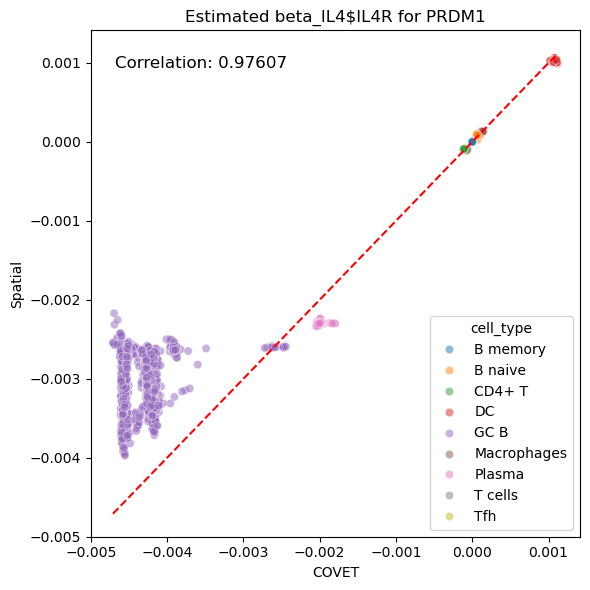

In [38]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr

plt.figure(figsize=(6, 6))
regulator = 'beta_IL4$IL4R'
x = betadata[regulator]
y = spatial_betadata[regulator]
celltypes = adata.obs['cell_type']
corr, _ = pearsonr(x, y)

sns.scatterplot(x=x, y=y, hue=celltypes, alpha=0.5)
plt.plot([min(x), max(x)], [min(x), max(x)], color='red', linestyle='--', label='y=x')
plt.text(0.05, 0.95, f'Correlation: {corr:.5f}', ha='left', va='top', transform=plt.gca().transAxes, fontsize=12, color='black')

plt.xlabel('COVET')
plt.ylabel('Spatial')
plt.title(f'Estimated {regulator} for {target_gene}')
plt.tight_layout()
plt.show()

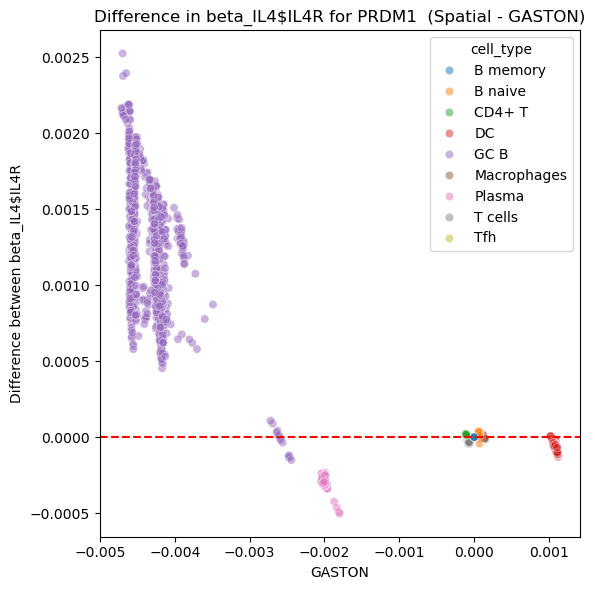

In [39]:
plt.figure(figsize=(6, 6))

x = betadata[regulator]
y = spatial_betadata[regulator]
celltypes = adata.obs['cell_type']

difference = y - x

sns.scatterplot(x=x, y=difference, hue=celltypes, alpha=0.5)

# Plot the y=x line for reference
plt.axhline(0, color='red', linestyle='--', label='Difference = 0')

plt.xlabel(f'{model_name}')
plt.ylabel(f'Difference between {regulator}')
plt.title(f'Difference in {regulator} for {target_gene}  (Spatial - {model_name})')

plt.tight_layout()


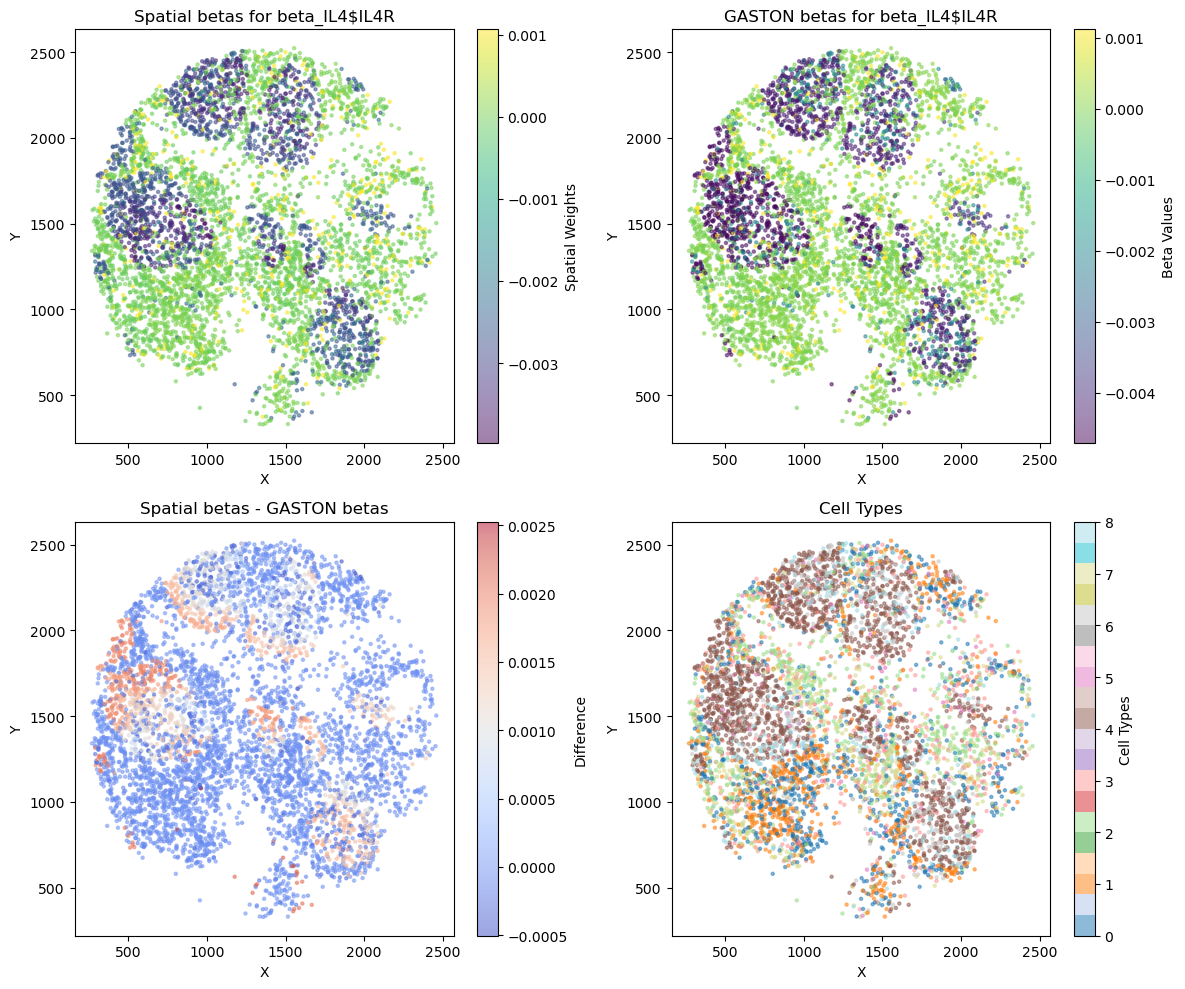

In [40]:
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

xy_coords = adata.obsm['spatial']
spot_size=5
alpha=0.5

weights = spatial_betadata[regulator]
spatial = axs[0, 0].scatter(xy_coords[:, 0], xy_coords[:, 1], c=weights, cmap='viridis', s=spot_size, alpha=alpha)
axs[0, 0].set_title(f"Spatial betas for {regulator}")
axs[0, 0].set_xlabel("X")
axs[0, 0].set_ylabel("Y")

beta = betadata[regulator]
covet = axs[0, 1].scatter(xy_coords[:, 0], xy_coords[:, 1], c=beta, cmap='viridis', s=spot_size, alpha=alpha)
axs[0, 1].set_title(f"{model_name} betas for {regulator}")
axs[0, 1].set_xlabel("X")
axs[0, 1].set_ylabel("Y")

difference = weights - beta
diff = axs[1, 0].scatter(xy_coords[:, 0], xy_coords[:, 1], c=difference, cmap='coolwarm', s=spot_size, alpha=alpha)
axs[1, 0].set_title(f"Spatial betas - {model_name} betas")
axs[1, 0].set_xlabel("X")
axs[1, 0].set_ylabel("Y")

cell_types = adata.obs['cell_type']  # Make sure this column exists in adata.obs
scatter = axs[1, 1].scatter(xy_coords[:, 0], xy_coords[:, 1], c=cell_types.astype('category').cat.codes, 
                            cmap='tab20', s=spot_size, alpha=alpha)
axs[1, 1].set_title("Cell Types")
axs[1, 1].set_xlabel("X")
axs[1, 1].set_ylabel("Y")

# Add colorbars
fig.colorbar(spatial, ax=axs[0, 0], orientation='vertical', label="Spatial Weights")
fig.colorbar(covet, ax=axs[0, 1], orientation='vertical', label="Beta Values")
fig.colorbar(diff, ax=axs[1, 0], orientation='vertical', label="Difference")
fig.colorbar(scatter, ax=axs[1, 1], orientation='vertical', label="Cell Types")

# Adjust layout for better spacing
plt.tight_layout()

In [41]:
import matplotlib.pyplot as plt

def plot_cell_type_data(adata, spatial_betadata, betadata, regulator, cell_type, spot_size=10, alpha=0.7):
    
    # Filter adata for only the specified cell type
    cell_filter = adata.obs['cell_type'] == cell_type
    xy_coords = adata.obsm['spatial'][cell_filter]
    weights = spatial_betadata[regulator][cell_filter]
    beta = betadata[regulator][cell_filter]
    difference = weights - beta
    cell_types = adata.obs['cell_type'][cell_filter]

    # Create the 2x2 subplot grid
    fig, axs = plt.subplots(2, 2, figsize=(12, 10))

    # First plot: spatial betas for the regulator
    spatial = axs[0, 0].scatter(xy_coords[:, 0], xy_coords[:, 1], c=weights, cmap='viridis', s=spot_size, alpha=alpha)
    axs[0, 0].set_title(f"Spatial betas for {regulator}")
    axs[0, 0].set_xlabel("X")
    axs[0, 0].set_ylabel("Y")

    # Second plot: COVET betas for the regulator
    covet = axs[0, 1].scatter(xy_coords[:, 0], xy_coords[:, 1], c=beta, cmap='viridis', s=spot_size, alpha=alpha)
    axs[0, 1].set_title(f"{model_name} betas for {regulator}")
    axs[0, 1].set_xlabel("X")
    axs[0, 1].set_ylabel("Y")

    # Third plot: Difference between spatial betas and COVET betas
    diff = axs[1, 0].scatter(xy_coords[:, 0], xy_coords[:, 1], c=difference, cmap='coolwarm', s=spot_size, alpha=alpha)
    axs[1, 0].set_title(f"Spatial betas - {model_name} betas")
    axs[1, 0].set_xlabel("X")
    axs[1, 0].set_ylabel("Y")

    # Fourth plot: Cell types (filtered by specified cell_type)
    scatter = axs[1, 1].scatter(xy_coords[:, 0], xy_coords[:, 1], c=cell_types.astype('category').cat.codes, 
                                cmap='tab20', s=spot_size, alpha=alpha)
    axs[1, 1].set_title(f"Cell Types ({cell_type})")
    axs[1, 1].set_xlabel("X")
    axs[1, 1].set_ylabel("Y")

    # Add colorbars
    fig.colorbar(spatial, ax=axs[0, 0], orientation='vertical', label="Spatial Weights")
    fig.colorbar(covet, ax=axs[0, 1], orientation='vertical', label="Beta Values")
    fig.colorbar(diff, ax=axs[1, 0], orientation='vertical', label="Difference")
    fig.colorbar(scatter, ax=axs[1, 1], orientation='vertical', label="Cell Types")

    # Adjust layout for better spacing
    plt.tight_layout()
    plt.show()



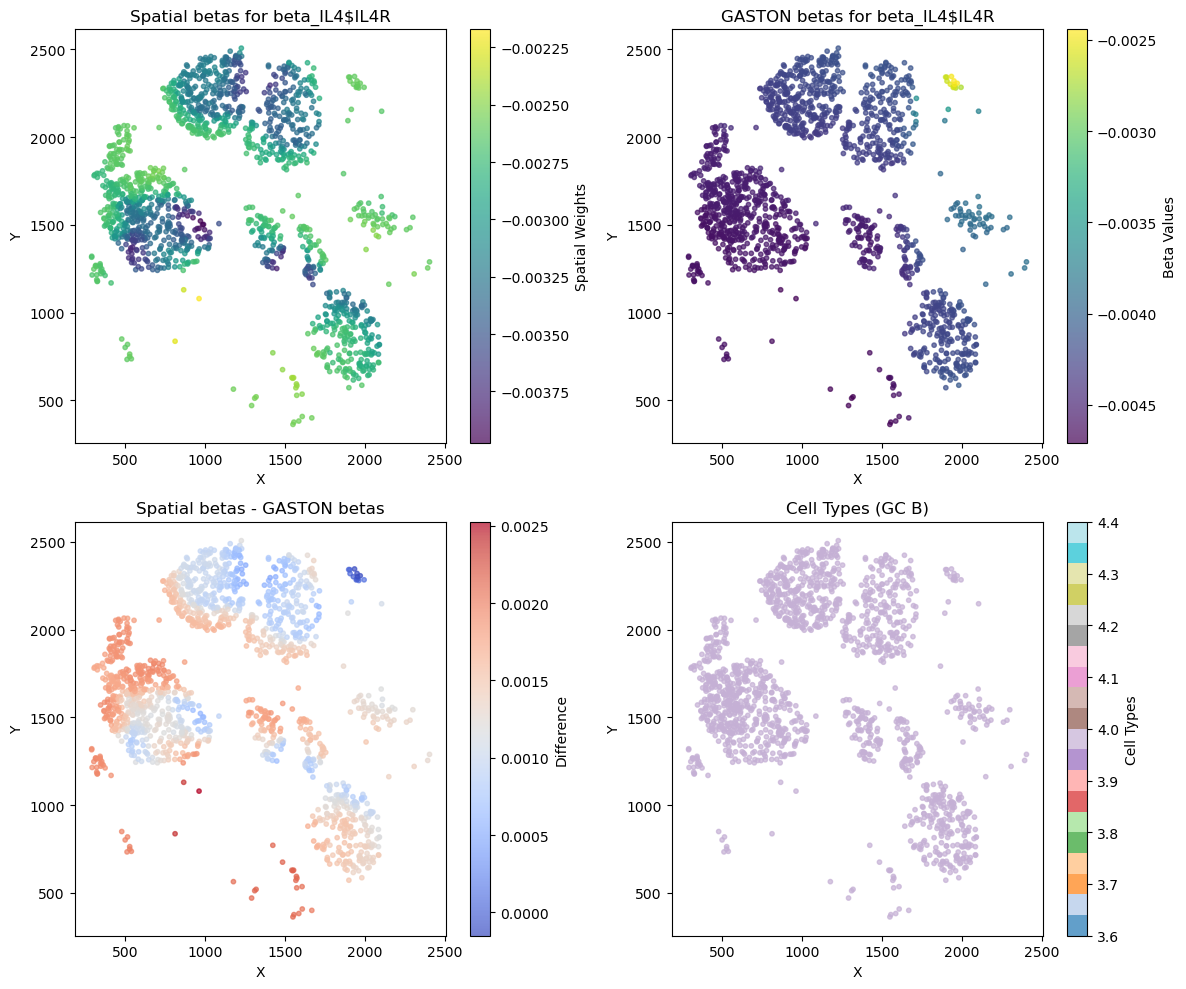

In [42]:
plot_cell_type_data(adata, spatial_betadata, betadata, regulator, 'GC B')
